In [1]:
## VISSIM Modules
import win32com.client as com
import os

## RL Modules
import tensorflow as tf

from tensorflow.keras.models import load_model
    
## Data Management Modules
import pickle

## User Defined Modules
import math
import Simulator_Functions as SF

from Actor_Critic_Agents import ACAgent



from NParser import NetworkParser
from COMServer import COMServerDispatch, COMServerReload
from TupleToList import toList
from Utilities import log_progress, pltlive
## Other Modules
import numpy as np
import random
import matplotlib.pyplot as plt
import PER

%matplotlib inline

In [2]:
## RL Hyperparamenters
# Number of simulations, save every "n" episodes 
episodes = 400
partial_save_at = 25 #50



# Hyperparameters
Surtrac = False
AC = True
PER_activated = False


alpha   = 0.000005
gamma   = 0.99
entropy = 0.00001 # exploration

# In order to reduce entropy during training
reduce_entropy = False
reduce_entropy_every = 1000

n_step_size = 16 # number of step in the n step learning 32

# Timesteps per simulation (1 timestep = 0.1 sec), length for random population is a multiple of episode
timesteps_per_second = 1
seconds_per_green = 6
seconds_per_yellow = 3
simulation_length = 3600*1 + 1 # worked with 2400



## State-Action Parameters
action_type = "phases"        # options are "phases" and "programs"
state_size = 33  #5 # 4 queues or 5 queues + signal state
action_size = 2

# Demand Schedule (times in seconds, demand in cars/hour as PPP) # worked with 600
demand_change_timesteps = 450
demand = {"h":600, 'm':300, 'l':150}
demand_list = [[demand['l'], demand['l']], [demand['m'], demand['l']],\
              [demand['h'], demand['l']], [demand['h'], demand['m']],\
              [demand['h'], demand['h']], [demand['m'], demand['h']],
              [demand['l'], demand['h']], [demand['l'], demand['m']]]


In [3]:
## Operation mode (selects functionalities)
mode = "training"
# "training" = training agents, maximum speed, frozen UI, mid amount of messages
# "debug"    = trains for 1 episode, minimum speed, working UI, all messages
# "demo"     = loads pretrained agent, minimum speed, working UI
# "test"     = executes evaluation, maximum speed




## Network Model Parameters
model_name  = 'Single_Cross_Mod2'
# 'Single_Cross_Straight'
# 'Single_Cross_Triple'
# 'Single_Cross_Triple_Mod'
# 'Single_Cross_Mod2'
# 'Balance'

vissim_working_directory =  'C:\\Users\\Rzhang\\Desktop\\MLforFlowOptimisationOrigine\\Vissim\\'
agent_type = 'AC' # DQN, DuelingDQN, DDQN, DuelingDDQN AC
reward_type = 'Queues'

state_type  = 'CellsSpeedOccSig'
#CellsSpeedOccSig'    # 'Queues', 'Delays', 'QueuesDifference' 'QueuesSpeedavrOccuperateSig' 'QueuesSig' CellsSpeedSig 
#CellsSpeedOccSig 'CellsOccSig' 'CellsT'
# 'Queues', 'Delays', 'QueuesDifference' 'QueuesSpeedavrOccuperateSig' 'QueuesSig'
Random_Seed = 42

## Use of additional files?
flag_read_additionally  = True
SaveResultsAgent = True
# Random demand
Random_Demand = False

# Session ID
#Session_ID = 'Ep_'+str(episodes)+'_A_'+agent_type+"_Act_"+action_type+"_Rew_"+reward_type

# Adding the state type to the Session_ID
Session_ID = 'Ep_'+str(episodes)+'_A_'+agent_type+"_State_"+state_type+"_Act_"+action_type+"_Rew_"+reward_type
print(Session_ID)

if mode == 'demo' :
    simulation_length = 3601
    demand_list = [[demand['l'], demand['l']]]
    demand_change_timesteps = simulation_length

if mode == 'test' : 
    simulation_length = 3601
    demand_change_timesteps = 450
    demand = {"h":800, 'm':400, 'l':200}
    demand_list = [[demand['l'], demand['l']], [demand['m'], demand['l']],\
                  [demand['h'], demand['l']], [demand['h'], demand['m']],\
                  [demand['h'], demand['h']], [demand['m'], demand['h']],
                  [demand['l'], demand['h']], [demand['l'], demand['m']]]
    Random_Seed = 1


Ep_400_A_AC_State_CellsSpeedOccSig_Act_phases_Rew_Queues


In [ ]:
# Have to find a way to reduce entropy over time entropy = exploration

## Converging network
# - reward queue, state queue
# converging with updates every steps and entropy = 0.00001 and 1 core layer of 42
# converging well with updates every steps and entropy = 0.00001 and no core

# - reward queue state queues + sig
# converging well with updates every steps and entropy = 0.00001 and no core

# 64 is a good number

if __name__ == "__main__":
    # Initialize storage
    reward_storage = []
    best_agent_weights = []
    best_agent_memory = []
    reward_plot = np.zeros([episodes,])
    loss_plot = np.zeros([episodes,])

    # Initialize simulation
    Vissim, Simulation, Network, cache_flag = COMServerDispatch(model_name, vissim_working_directory,\
                                                                simulation_length, timesteps_per_second,\
                                                                delete_results = True, verbose = True)
    SF.Select_Vissim_Mode(Vissim,mode)
    
    runflag = True
    # Setting Random Seed
    Vissim.Simulation.SetAttValue('RandSeed', Random_Seed)
    print ('Random seed set in simulator. Random Seed = '+str(Random_Seed))

    # Deploy Network Parser (crawl network)
    npa = NetworkParser(Vissim)
    print('NetworkParser has succesfully crawled the model network.')
    
    # Initialize agents
    if agent_type in ['AC'] :
        Agents = [ACAgent(state_size, action_size, ID, state_type, npa, n_step_size, gamma, alpha, entropy, Vissim) for ID in npa.signal_controllers_ids] 
        for agent in Agents:
            # to initialise the computational graph ot the model (I am sure there is a better way to to this)
            agent.test()
        agents_deployed = True
    else:
        print("Incorrect Agent Class selected. Deployment could not be completed.")
        quit()
    if agents_deployed:
        print("Deployed {} agent(s) of the Class {}.".format(len(Agents), agent_type))
    
    ## EXECUTION OF A DEMONSTRATION RUN (slow, choice of best available agent)
    if mode == "demo" or mode == "populate" or mode == "debug" or mode == "test":
        # If mode or debug, set slow simulation
        if mode == "demo" or mode =="debug":
            timesteps_per_second = 10
            Vissim.Simulation.SetAttValue('SimRes', timesteps_per_second)
            
        # If memory population or test mode, set quick simulation
        elif mode == "populate" or mode == "test":
            SF.Set_Quickmode(Vissim, timesteps_per_second)
            
        # If on a test or a demo, load the best available agent and set exploration to zero
        if mode == "demo" or mode == "test":
            Agents , reward_storage = SF.load_agents(vissim_working_directory, model_name, Agents,\
                                    Session_ID, best = True)
            for agent in Agents:
                agent.epsilon = 0
                
    # Run the episode
        if mode == "demo" or mode == "debug":
            SF.run_simulation_episode(Agents, Vissim, state_type, reward_type, state_size, simulation_length,\
                                      timesteps_per_second, seconds_per_green, seconds_per_yellow,\
                                      demand_list, demand_change_timesteps, mode, PER_activated)
        elif mode == "test":
            SF.run_simulation_episode(Agents, Vissim, state_type, reward_type, state_size, simulation_length,\
                                      timesteps_per_second, seconds_per_green, seconds_per_yellow,\
                                      demand_list, demand_change_timesteps, mode, PER_activated)
        elif mode == "populate":
            if PER_activated:
                memory, Agents, runflag = SF.prepopulate_memory(Agents, Vissim, state_type, reward_type, state_size, memory_size,\
                                                                vissim_working_directory, model_name, Session_ID,\
                                                                seconds_per_green, seconds_per_green, timesteps_per_second,\
                                                                demand_list, demand_change_timesteps, PER_activated)
                print("PER memory prepopulated with {} entries".format(memory_size))
        
        Vissim = None
    
    ## EXECUTION OF THE NORMAL TRAINING LOOP
    elif mode == "training":
        print("Training")
        
            
        # Iterations of the simulation
        for episode in log_progress(range(episodes), every=1):
        
            # Reload map if it has already been run (previous episode or prepopulation)
            if episode !=0 or runflag == True:
                Simulation, Network = COMServerReload(Vissim, model_name, vissim_working_directory,\
                                                      simulation_length, timesteps_per_second, delete_results = True)

                # Run Network Parser and ensure agents are linked to their intersections
                #npa.update(Vissim) 
                npa = NetworkParser(Vissim)
                for index, agent in enumerate(Agents):
                    #agent.update_IDS(npa.signal_controllers_ids[index], npa)
                    agent.update_IDS(agent.signal_id, npa)
                    agent.episode_reward = []

            # Change the random seed
            Random_Seed += 1
            Vissim.Simulation.SetAttValue('RandSeed', Random_Seed)
        
            # Run Episode at maximum speed
            
            SF.Select_Vissim_Mode(Vissim, mode)
            
            SF.run_simulation_episode(Agents, Vissim, state_type, reward_type, state_size, simulation_length, timesteps_per_second,\
                                      seconds_per_green, seconds_per_yellow, demand_list, demand_change_timesteps, mode,\
                                      PER_activated,Surtrac = Surtrac)
        
            # Calculate episode average reward
            reward_storage, average_reward = SF.average_reward(reward_storage, Agents, episode, episodes)
            best_agent_weights, best_agent_memory = SF.best_agent(reward_storage, average_reward,\
                                                                  best_agent_weights, best_agent_memory,\
                                                                  vissim_working_directory, model_name, Agents, Session_ID)
        
            
            # Security save for long trainings
            if SaveResultsAgent:
                if (episode+1)%partial_save_at == 0:
                    SF.save_agents(vissim_working_directory, model_name, Agents, Session_ID, reward_storage)
                    print('Saved Partial results at the end of episode {}.'.format(episode+1))
            
            # line to reduce the entropy of the actor_critic.
            if reduce_entropy:
                pass
            
        #Saving agents memory, weights and optimizer
        if SaveResultsAgent:
            SF.save_agents(vissim_working_directory, model_name, Agents, Session_ID, reward_storage)
            print("Model, architecture, weights, optimizer, memory and training results succesfully saved.\
            Succesfully Terminated.")
    
    else:
        print("ERROR: Mode selected not recognized. TERMINATING.")
    # Close Vissim
    Vissim = None

Working Directory set to: C:\Users\Rzhang\Desktop\MLforFlowOptimisationOrigine\Vissim\
Generating Cache...
Cache generated.

****************************
*   COM Server dispatched  *
****************************

Attempting to load Model File: Single_Cross_Mod2.inpx ...
Load process successful
Simulation length set to 3601 seconds.
Results from Previous Simulations: Deleted. Fresh Start Available.
Fetched and containerized Simulation Object
Fetched and containerized Network Object 

*******************************************************
*                                                     *
*                 SETUP COMPLETE                      *
*                                                     *
*******************************************************

Random seed set in simulator. Random Seed = 42
NetworkParser has succesfully crawled the model network.
Deploying instance of Actor_Critic Agent(s) !!! TENSORFLOW 2 IS NEEDED !!! 
Deployed 1 agent(s) of the Class AC.
Training


Episode: 1/400, Epsilon:0, Average reward: -254.8
New best agent found. Saved in C:\Users\Rzhang\Desktop\MLforFlowOptimisationOrigine\Vissim\Single_Cross_Mod2\Agents_Results\Ep_400_A_AC_State_CellsSpeedOccSig_Act_phases_Rew_Queues\BestAgent0_Memory.p
Episode: 2/400, Epsilon:0, Average reward: -261.93
Episode: 3/400, Epsilon:0, Average reward: -242.35
New best agent found. Saved in C:\Users\Rzhang\Desktop\MLforFlowOptimisationOrigine\Vissim\Single_Cross_Mod2\Agents_Results\Ep_400_A_AC_State_CellsSpeedOccSig_Act_phases_Rew_Queues\BestAgent0_Memory.p
Episode: 4/400, Epsilon:0, Average reward: -240.17
New best agent found. Saved in C:\Users\Rzhang\Desktop\MLforFlowOptimisationOrigine\Vissim\Single_Cross_Mod2\Agents_Results\Ep_400_A_AC_State_CellsSpeedOccSig_Act_phases_Rew_Queues\BestAgent0_Memory.p
Episode: 5/400, Epsilon:0, Average reward: -223.1
New best agent found. Saved in C:\Users\Rzhang\Desktop\MLforFlowOptimisationOrigine\Vissim\Single_Cross_Mod2\Agents_Results\Ep_400_A_AC_State_Ce

In [ ]:
# Plotting training progress
plt.figure(figsize=(8,4.5))
x_series = range(1,len(reward_storage)+1)
fit = np.polyfit(x_series,reward_storage,1)
fit_fn = np.poly1d(fit) 
plt.plot(x_series,reward_storage, '-b', x_series, fit_fn(x_series), '--r')
plt.xlabel('Episodes')
plt.ylabel('Average agent reward in episode')
plt.title('Training evolution and trend')
plt.gca().legend(('Episode Reward','Linear Trend'))
plt.show()

# Plotting training loss
plt.figure(figsize=(8,4.5))
x_series = range(1,len(Agents[0].loss)+1)
plt.plot(x_series,Agents[0].loss, '-b')
plt.xlabel('Training Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.gca().legend(('Loss'))
plt.show()

print(reward_storage)

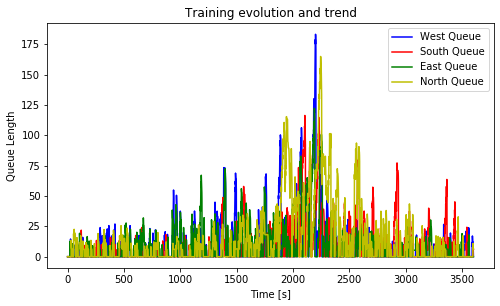

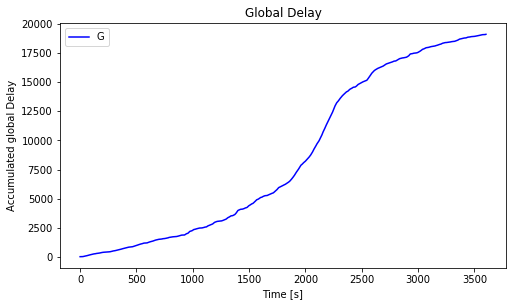

Average queue size is 10.25


In [14]:
# Plotting test progress:
West_queue = list()
South_queue= list()
East_queue = list()
North_queue= list()
# Queue Lengths
plt.figure(figsize=(8,4.5))
x_series = range(1,len(Agents[0].queues_over_time)+1)
for i in range(len(Agents[0].queues_over_time)):
    West_queue.append(Agents[0].queues_over_time[i][0])
    South_queue.append(Agents[0].queues_over_time[i][1])
    East_queue.append(Agents[0].queues_over_time[i][2])
    North_queue.append(Agents[0].queues_over_time[i][3])
plt.plot(x_series, West_queue, '-b',\
         x_series, South_queue, '-r',\
         x_series, East_queue, '-g',\
         x_series, North_queue, '-y')
plt.xlabel('Time [s]')
plt.ylabel('Queue Length')
plt.title('Training evolution and trend')
plt.gca().legend(('West Queue','South Queue', 'East Queue', 'North Queue'))
plt.show()

# Accumulated delay over time
plt.figure(figsize=(8,4.5))
x_series = range(1,len(Agents[0].accumulated_delay)+1)
plt.plot(x_series,Agents[0].accumulated_delay, '-b')
plt.xlabel('Time [s]')
plt.ylabel('Accumulated global Delay')
plt.title('Global Delay')
plt.gca().legend('GLlobal accumulated delay')
plt.show()

average_queue_length = np.mean(Agents[0].queues_over_time)
print("Average queue size is {}".format(np.round(average_queue_length,2)))